In [30]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt
import random
import time
import math

In [2]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+bias,self.precision)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_gradings):
        self.n_gradings = n_gradings
        # Distribute handins
        for i in xrange(0,n_gradings):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()
            
class Course(object):
    
    def __init__(self):
        self.assignments = list()
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = 0
    
    def add_assignment(self,assignment):
        self.assignments.append(assignment)
        for a in self.assignments:
            self.handins.update(a.handins)
            self.graders.update(a.graders)
        self.n_gradings = self.n_gradings + a.n_gradings

In [3]:
course = Course()

T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,60):
    g = grader('%i' % i,B_mu.random(),B_tau.random())
    graders_data.append(g)
for i in xrange(0,60):    
    t_mu = random_limit(T_mu)
    h = handin('%i' % i, graders_data[i], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data = assignment(handins_data,graders_data)
assignment_data.grade_handins(5)
course.add_assignment(assignment_data)

In [4]:
handins_data = list()

for i in xrange(60,120):
    t_mu = random_limit(T_mu)
    h = handin('%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(5)
course.add_assignment(assignment_data_2)

In [108]:
handins_data = list()

for i in xrange(120,180):
    t_mu = random_limit(T_mu)
    h = handin('%i' % i, graders_data[i-120], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(5)
course.add_assignment(assignment_data_3)

## Gibbs Implementation

In [106]:
def gibbs_model(data):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    e = np.random.gamma(al_e,1.0/be_e)
    for h in range(N_H):
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_g * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in range(N_G):
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))

    # Gibbs sampling
    
    burn_in = 1000  # warm-up steps
    samples = 5000 # Gibbs sampling steps
    
    # Tracers initialising
    trace_e = list()
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    trace_T = defaultdict(list)
    trace_B = defaultdict(list)
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h in range(N_H):
            handin = data.handins[str(h)]
            n_gradings = len(handin.graders)
            sum_ = 0.0
            for g, val in handin.gradeings.iteritems():
                sum_ = sum_ + val - B[int(g)]
            v = e*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+e*sum_)/v,np.sqrt(1/v))
            
        # Sample B
        for g in range(N_G):
            grader = data.graders[str(g)]
            n_gradings = len(grader.handins)
            sum_ = 0.0
            for h in grader.handins:
                sum_ = sum_ + h.gradeings[str(g)] - T[int(h.title)]
            v = e*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+e*sum_)/v,np.sqrt(1/v))
        
        # Sample e
        sum_ = 0.0
        for h in range(N_H):
            for g, grading in data.handins[str(h)].gradeings.iteritems():
                sum_ = sum_ + np.square(grading - (T[int(h)]+B[int(g)]))
        e = np.random.gamma(al_e+0.5*N_eval,1.0/(be_e+0.5*sum_))

        # Sample u_h and t_h
        for h in range(N_H):
            la_ = (la_h+1.0)
            al_ = al_h + 0.5 * la_h + 0.5 * np.square(T[h]-u_h[h])
            be_ = be_h + 0.5 + 0.5 * 1.0
#            al_ = al_h+0.5
#            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0/(la_*t_h[h])))

        # Sample u_g and t_g
        for g in range(N_G):
            la_ = (la_g+1)
            al_ = al_g + 0.5 * la_g + 0.5 * np.square(B[g]-u_g[g])
            be_ = be_g + 0.5 + 0.5 * 1
#            al_ = al_g+0.5
#            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0/(t_g[g])))
            
        # Collect tracings
        if r > burn_in:
            trace_e.append(e)
            for h in range(N_H):
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
                trace_T[h].append(T[h])
            for g in range(N_G):
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                trace_B[g].append(B[g])
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'e' : trace_e,
              'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g,
              'T' : trace_T,
              'B' : trace_B}

    return traces

In [109]:
traces = gibbs_model(course)

6000 out of 6000
Wall time: 105.409056


## Metropolish Hasting

In [27]:
def norm_log_pdf(x,u,t):
    return -0.5*t*(x-u)**2+np.log(t)-np.log(np.sqrt(2.0*math.pi))

def gamma_log_pdf(x,a,b):
    return a*np.log(b)-np.log(math.gamma(a))+(a-1.0)*np.log(x)-b*x

def norm_gamma_log_pdf(u,t,ga,la,a,b):
    return a*np.log(b)+np.log(np.sqrt(la))-np.log(math.gamma(a))-np.log(np.sqrt(2.0*math.pi))+(a-1)*np.log(t)-np.log(b*t)-0.5*t*la*(u-ga)**2

In [31]:
def MH_model(data):

    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    
    log_h = dict()
    log_g = dict()

    def prop_u_t_h(handin,u_h,t_h):
        sum_ = 0.0
        for g, val in handin.gradeings.iteritems():
            sum_ = sum_ + norm_log_pdf(val,u_g[int(g)]+u_h,t_g[int(g)]+t_h)
        return sum_ + norm_gamma_log_pdf(u_h,t_h,ga_h,la_h,al_h,be_h)
    
    def prop_u_t_g(grader,g,u_g,t_g):
        sum_ = 0.0
        for h in grader.handins:
            val = h.gradeings[str(g)]
            sum_ = sum_ + norm_log_pdf(val,u_g+u_h[int(h.title)],t_g+t_h[int(h.title)])
        return sum_ + norm_gamma_log_pdf(u_g,t_g,ga_g,la_g,al_g,be_g)

    
    # Draw from priors
    for h in range(N_H):
        t_h[h] = np.random.gamma(al_h,1/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1/(la_g * t_h[h])))
    for g in range(N_G):
        t_g[g] = np.random.gamma(al_g,1/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1/(la_g * t_g[g]))) 
    for h in range(N_H):
        handin = data.handins[str(h)]
        log_h[h] = prop_u_t_h(handin,u_h[h],t_h[h])
    for g in range(N_G):
        grader = data.graders[str(g)]
        log_g[g] =prop_u_t_g(grader,g,u_g[g],t_g[g])
        
    # Gibbs sampling
    
    burn_in = 4000  # warm-up steps
    samples = 8000 # Gibbs sampling steps    
    
    # Tracers initialising
    trace_u_h = defaultdict(list)
    trace_t_h = defaultdict(list)
    trace_u_g = defaultdict(list)
    trace_t_g = defaultdict(list)
    
    ## Acception ratior
    accepted_h = 0.0
    accepted_g = 0.0

    
    tw = time.time()
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        
        # Sample u_h and t_h
        for h in range(N_H):
            handin = data.handins[str(h)]
            # Propose new candidates
            u_h_c = np.random.normal(u_h[h],0.1)
            t_h_c = np.random.normal(t_h[h],0.1)
            #draw from gamma
            p_ = prop_u_t_h(handin,u_h_c,t_h_c)
            alpha = min(1,p_-log_h[h])
            if np.log(np.random.random()) <= alpha:
                accepted_h = accepted_h+1.0
                u_h[h] = u_h_c
                t_h[h] = t_h_c
                log_h[h] = p_
                    
        # Sample u_g and t_g
        for g in range(N_G):
            grader = data.graders[str(g)]
            # Propose new candidates
            u_g_c = np.random.normal(u_g[g],0.1)
            t_g_c = np.random.normal(t_g[g],0.1)
            #draw from gamma
            p_ = prop_u_t_g(grader,g,u_g_c,t_g_c)
            alpha = min(1,p_-log_g[g])
            if np.log(np.random.random()) <= alpha:
                accepted_g = accepted_g + 1.0
                u_g[g] = u_g_c
                t_g[g] = t_g_c    
                log_g[g] = p_

        # Collect tracings
        if r > burn_in:
            for h in range(N_H):
                trace_u_h[h].append(u_h[h])
                trace_t_h[h].append(t_h[h])
            for g in range(N_G):
                trace_u_g[g].append(u_g[g])
                trace_t_g[g].append(t_g[g])
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    
    traces = {'u_h' : trace_u_h,
              't_h' : trace_t_h,
              'u_g' : trace_u_g,
              't_g' : trace_t_g}

    return traces

In [110]:
traces_MH = MH_model(course)

12000 out of 12000
Wall time: 436.934235


### Data Plot

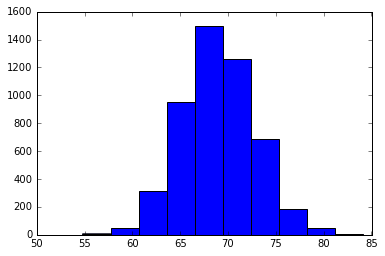

In [111]:
plt.hist(traces['e'])
plt.show()

In [112]:
def plot_scores(scores):
    ax = plt.subplot(111)
    
    scores.sort(key=lambda x:x[1])
    print "Gibbs MSE:" ,
    print sum(map(lambda x : (float(x[2]) - float(x[1])) ** 2,scores)) / len(scores)
    print "MH MSE:" ,
    print sum(map(lambda x : (float(x[3]) - float(x[1])) ** 2,scores)) / len(scores)
    model_1 = map(lambda x : float(x[2]),scores)
    model_2 = map(lambda x : float(x[3]),scores)

    true = map(lambda x : float(x[1]),scores)
    label = map(lambda x : float(x[0]),scores)
    y = xrange(0,len(scores))
    if len(scores[0]) > 4:
        print "Mean MSE:" ,
        print sum(map(lambda x : (float(x[4]) - float(x[1])) ** 2,scores)) / len(scores)
        mean = map(lambda x : float(x[4]),scores)
        plt.plot(mean,y,'+m',label="Mean",alpha=0.8)
    plt.plot(model_1,y,'or',label="Gibbs sampling",alpha=0.65)
    plt.plot(model_2,y,'og',label="MH sampling",alpha=0.65)
    plt.plot(true,y,'.b',label="True score")
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*3])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)

Gibbs MSE: 0.000855504378
MH MSE: 0.000957350019858


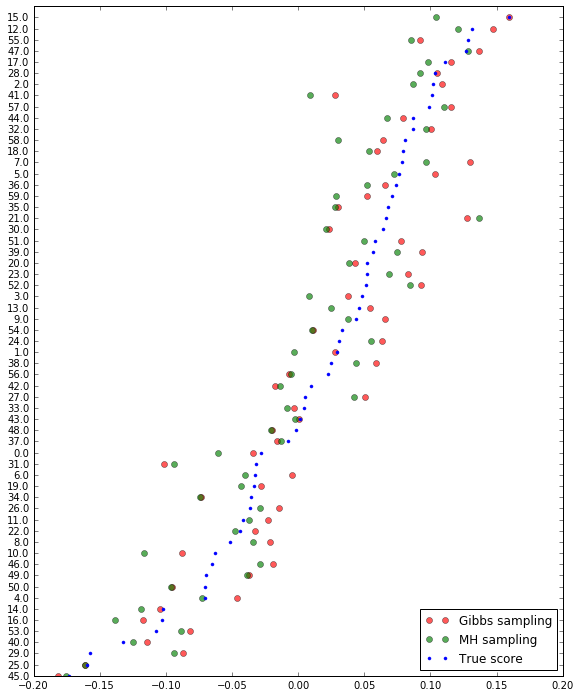

In [113]:
scores = list()
for name, g in course.graders.iteritems():
    scores.append((name,float(g.bias_mean),np.mean(traces['B'][int(name)]),np.mean(traces_MH['u_g'][int(name)])))
plot_scores(scores)

Gibbs MSE: 0.00259576584416
MH MSE: 0.00265061902792
Mean MSE: 0.0030948970534


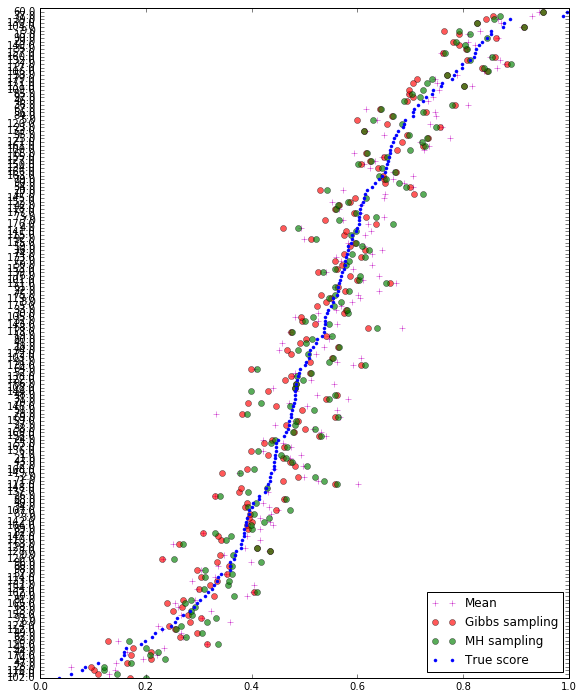

In [114]:
scores = list()
for title, h in course.handins.iteritems():
    mean = np.mean(h.gradeings.values())
    scores.append((title,float(h.true_val),np.mean(traces['T'][int(title)]),np.mean(traces_MH['u_h'][int(title)]),mean))
plot_scores(scores)

Gibbs MSE: 200993.857677
MH MSE: 8175.6978376


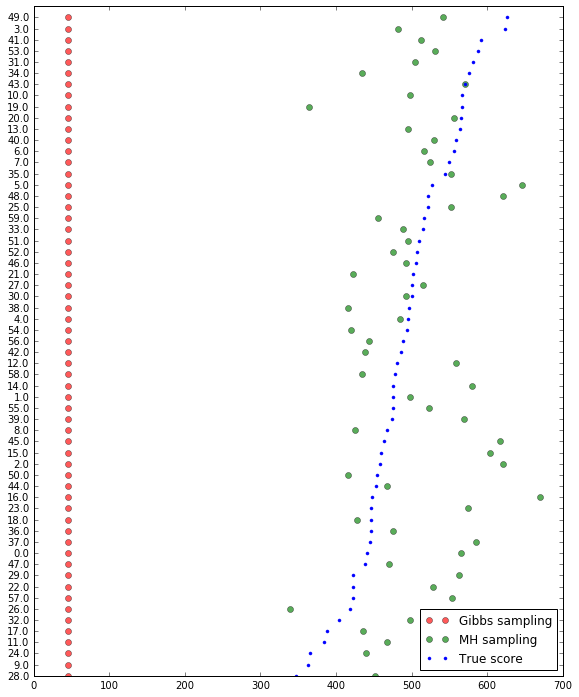

In [115]:
scores = list()
for name, g in course.graders.iteritems():
    scores.append((name,float(g.bias_tau),np.mean(traces['t_g'][int(name)]),np.mean(traces_MH['t_g'][int(name)])))
plot_scores(scores)

Gibbs MSE: 9663.25038047
MH MSE: 1779.23968249


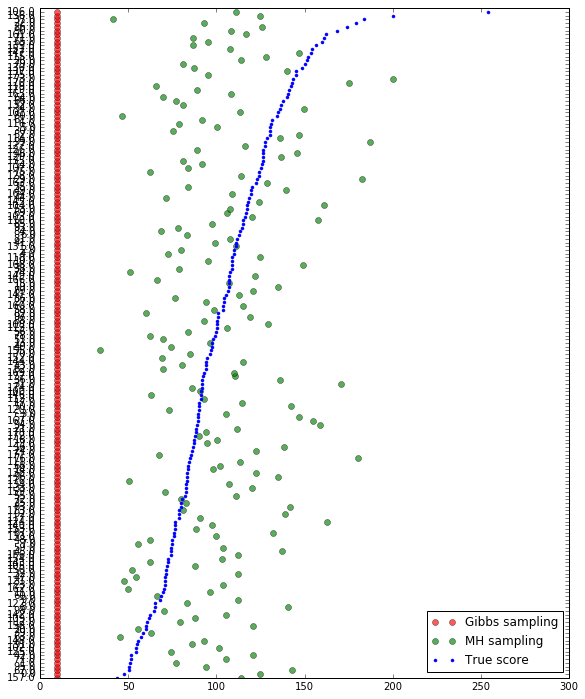

In [116]:
scores = list()
for title, h in course.handins.iteritems():
    scores.append((title,float(h.precision),np.mean(traces['t_h'][int(title)]),np.mean(traces_MH['t_h'][int(title)])))

plot_scores(scores)

# Gibbs VS Metropolish-Hastings

In [ ]:
data = [('1 ass, 5 gradings',(1,5),[(10,(52.926037,17.394718),(0.00741566416253,0.0038712763065)),
                                    (25,(135.434134,83.110631),(0.00172148892856,0.00198619501123)),
                                    (50,(263.826781,251.480387),(0.00311335560883,0.00333418202202)),
                                    (75,(405.950860,623.360426),(0.00342984235016,0.00357793749179)),
                                    (100,(510.913396,2178.053913),(0.0027808105486,0.00291477169647))]),
        ('1 ass, 10 gradings',(1,10),[(11,(92.606165,29.251512),(0.000920858289528,0.000909238545598)),
                                      (25,(209.142092,85.174184),(0.00191445167068,0.00207297092275)),
                                      (50,(441.984698,412.450215),(0.00265583792402,0.00253389142967)),
                                      (75,(680.459289,525.915773),(0.00202617517182,0.0021086392097)),
                                      (100,(896.673104,1450.916012),(0.00167275229378,0.00198124916808))]),
        ('2 ass, 5 gradings',(2,5),[(10,(95.868462,34.399942),(0.00159022225517,0.00161970533525)),
                                    (25,(238.818824,104.504534),(0.00221384241717,0.00223938034666)),
                                    (50,(493.209580,662.198828),(0.00223482632479,0.0023394252599)),
                                    (75,(789.314926,1281.555315),(0.00181455776138,0.00184482617533)),
                                    (100,(1038.258642,2829.493589),(0.00180588098216,0.0022923245892))]),
        ('3 ass, 5 gradings',(3,5),[(10,(95.868462,34.399942),(0.00159022225517,0.00161970533525)),
                                    (25,(238.818824,104.504534),(0.00221384241717,0.00223938034666)),
                                    (50,(493.209580,662.198828),(0.00223482632479,0.0023394252599)),
                                    (75,(789.314926,1281.555315),(0.00181455776138,0.00184482617533)),
                                    (100,(1038.258642,2829.493589),(0.00180588098216,0.0022923245892))])]